# Week 10: PDEs - Implicit Methods

---

## Learning Objectives

By the end of this lecture, you should be able to:
1. Understand the difference between explicit and implicit methods for solving PDEs
2. Formulate the diffusion equation using matrix notation
3. Implement both explicit and implicit FTCS schemes
4. Analyze stability conditions using eigenvalue analysis
5. Apply appropriate boundary conditions in matrix form

## 1. The Diffusion Equation

The 1D diffusion equation describes how temperature (or concentration) spreads over time:

$$\frac{\partial T(x,t)}{\partial t} = \kappa \frac{\partial^2 T(x,t)}{\partial x^2}$$

where:
- $T(x,t)$ = temperature at position $x$ and time $t$
- $\kappa$ = thermal diffusion coefficient
- Domain: $x \in [-L/2, L/2]$

## 2. Discretization

### Spatial Grid
Divide space into $N$ grid points with spacing $h$:

$$x_i = ih - L/2, \quad i = 0, 1, 2, \ldots, N-1$$
$$h = \frac{L}{N-1}$$

### Temporal Grid
Divide time into steps with spacing $\tau$:

$$t_n = n\tau, \quad n = 0, 1, 2, \ldots$$

### Notation
$$T_i^n = T(x_i, t_n)$$

## 3. Finite Difference Approximations

### Time Derivative (Forward Difference)
$$\frac{\partial T}{\partial t} \approx \frac{T_i^{n+1} - T_i^n}{\tau}$$

### Space Derivative (Centered Difference)
$$\frac{\partial^2 T}{\partial x^2} \approx \frac{T_{i+1}^n + T_{i-1}^n - 2T_i^n}{h^2}$$

### FTCS Scheme
Substituting into the diffusion equation:

$$T_i^{n+1} = T_i^n + \frac{\kappa\tau}{h^2}\left(T_{i+1}^n + T_{i-1}^n - 2T_i^n\right)$$

## 4. Matrix Formulation

### Explicit FTCS
We can write the update equation in matrix form:

$$\mathbf{T}^{n+1} = \mathbf{T}^n + \frac{\kappa\tau}{h^2}\mathbf{D}\mathbf{T}^n = \left(\mathbf{I} + \frac{\kappa\tau}{h^2}\mathbf{D}\right)\mathbf{T}^n = \mathbf{A}\mathbf{T}^n$$

where $\mathbf{D}$ is the discrete Laplacian matrix.

### The Matrix D

The matrix $\mathbf{D}$ implements the centered difference for the second derivative:

$$\mathbf{D} = \begin{pmatrix}
-2 & 1 & 0 & 0 & \cdots & 0 \\
1 & -2 & 1 & 0 & \cdots & 0 \\
0 & 1 & -2 & 1 & \cdots & 0 \\
\vdots & \vdots & \ddots & \ddots & \ddots & \vdots \\
0 & 0 & \cdots & 1 & -2 & 1 \\
0 & 0 & \cdots & 0 & 1 & -2
\end{pmatrix}$$

Structure:
- **Diagonal**: $-2$ (coefficient for $T_i^n$)
- **Off-diagonals**: $+1$ (coefficients for $T_{i-1}^n$ and $T_{i+1}^n$)
- **Elsewhere**: $0$

## 5. Boundary Conditions

### Type 1: Dirichlet Boundary Conditions
Fix the temperature at boundaries:
$$T_0^n = \text{const}, \quad T_{N-1}^n = \text{const}$$

**Implementation**: Set rows 0 and $N-1$ of matrix $\mathbf{D}$ to zero.

### Type 2: Periodic Boundary Conditions
Temperature wraps around:
$$T_0^n = T_{N-1}^n$$

**Implementation**: Set off-diagonal corners of $\mathbf{D}$ to 1:
- $D[0, N-1] = 1$
- $D[N-1, 0] = 1$

## 6. Stability Analysis via Eigenvalues

### Theoretical Background
Since we can write:
$$\mathbf{T}^{n+1} = \mathbf{A}^n \mathbf{T}^1$$

If we express $\mathbf{T}$ in terms of the eigenvectors of $\mathbf{A}$ (see equations 9.15-9.18 in textbook):
$$\mathbf{T}^n = \sum_k c_k \lambda_k^n \mathbf{v}_k$$

where $\lambda_k$ are eigenvalues and $\mathbf{v}_k$ are eigenvectors of $\mathbf{A}$.

### Stability Criterion
Multiplying $\mathbf{T}$ by $\mathbf{A}$ $n$ times involves multiplying by eigenvalues $n$ times, or $(\lambda_k)^n$.

**For stability:** We need $|\lambda_k| \leq 1$ for all eigenvalues.

**If $|\lambda_k| > 1$:** The solution diverges → **unstable**!

### Critical Time Step for Explicit FTCS
For the explicit FTCS method applied to the diffusion equation, eigenvalue analysis shows that stability requires:
$$\tau < \frac{h^2}{2\kappa} \equiv t_{\sigma}$$

or equivalently:
$$\frac{\kappa\tau}{h^2} < \frac{1}{2}$$

## 7. Implicit Method

### Forward Time, Centered Space (FTCS) - Implicit Version
The implicit method uses:
- **Forward time derivative** (same as explicit)
- **Spatial derivatives evaluated at future time** $n+1$ (this is what makes it implicit!)

$$\frac{T_i^{n+1} - T_i^n}{\tau} = \kappa\frac{T_{i+1}^{n+1} + T_{i-1}^{n+1} - 2T_i^{n+1}}{h^2}$$
Note: The spatial terms on the right use $n+1$ (unknown values), not $n$ (known values).

### Matrix Form
$$\mathbf{T}^{n+1} - \frac{\kappa\tau}{h^2}\mathbf{D}\mathbf{T}^{n+1} = \mathbf{T}^n$$

$$\left(\mathbf{I} - \frac{\kappa\tau}{h^2}\mathbf{D}\right)\mathbf{T}^{n+1} = \mathbf{T}^n$$

### Solution
$$\mathbf{T}^{n+1} = \left(\mathbf{I} - \frac{\kappa\tau}{h^2}\mathbf{D}\right)^{-1}\mathbf{T}^n = \mathbf{A}\mathbf{T}^n$$

where $\mathbf{A} = \left(\mathbf{I} - \frac{\kappa\tau}{h^2}\mathbf{D}\right)^{-1}$

**Note**: Implicit method is **unconditionally stable** (no restriction on $\tau$)!

## 8. Implementation

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

### Explicit FTCS Implementation

In [15]:
def diffusion_ftcs_explicit(nspace, ntime, tau_rel, args=[1.0, 1.0]):
    """ 
    Compute the solution to the diffusion equation using 
    the explicit forward-time, centered-space algorithm
    in matrix formulation
    
    Parameters:
    -----------
    nspace : int
        Number of spatial grid points
    ntime : int
        Number of time grid points
    tau_rel : float
        Timestep in units of t_sigma = h²/(2κ)
    args : list
        [L, kappa] - domain size and diffusion coefficient
        
    Returns:
    --------
    tt : ndarray
        2D array of shape (nspace, ntime) containing T(x,t)
    """
    # Check stability
    if tau_rel < 1.0:
        print('✓ Solution is expected to be stable')
    else:
        print('⚠ WARNING: Solution is expected to be unstable')
        
    # Physical parameters
    L = args[0]        # System size
    kappa = args[1]    # Diffusion coefficient
    
    # Grid parameters
    h = L / (nspace - 1)           # Grid spacing
    t_sigma = h**2 / (2 * kappa)   # Critical time step
    tau = tau_rel * t_sigma        # Actual time step
    coeff = kappa * tau / h**2     # Coefficient for matrix
    
    print(f'Grid spacing h = {h:.6f}')
    print(f'Critical time step t_σ = {t_sigma:.6f}')
    print(f'Actual time step τ = {tau:.6f}')
    print(f'Coefficient κτ/h² = {coeff:.6f}')

    # Initialize temperature array
    tt = np.zeros((nspace, ntime))
    
    # Initial condition: delta function in center
    tt[int(nspace/2), 0] = 1.0 / h
    
    # Construct matrix D (discrete Laplacian)
    D = -2 * np.identity(nspace) + \
        np.diagflat(np.ones(nspace-1), 1) + \
        np.diagflat(np.ones(nspace-1), -1)
    
    # Apply Dirichlet boundary conditions
    D[0, :] = 0
    D[-1, :] = 0
    
    # Construct evolution matrix A for explicit method
    A = np.identity(nspace) + coeff * D
    
    # Time evolution loop
    for istep in range(1, ntime):
        tt[:, istep] = A.dot(tt[:, istep-1])
        
    return tt

### Implicit FTCS Implementation

In [3]:
def diffusion_ftcs_implicit(nspace, ntime, tau_rel, args=[1.0, 1.0]):
    """ 
    Compute the solution to the diffusion equation using 
    the implicit backward-time, centered-space algorithm
    in matrix formulation
    
    Parameters:
    -----------
    nspace : int
        Number of spatial grid points
    ntime : int
        Number of time grid points
    tau_rel : float
        Timestep in units of t_sigma = h²/(2κ)
    args : list
        [L, kappa] - domain size and diffusion coefficient
        
    Returns:
    --------
    tt : ndarray
        2D array of shape (nspace, ntime) containing T(x,t)
    """
    print('Using implicit method (unconditionally stable)')
        
    # Physical parameters
    L = args[0]
    kappa = args[1]
    
    # Grid parameters
    h = L / (nspace - 1)
    t_sigma = h**2 / (2 * kappa)
    tau = tau_rel * t_sigma
    coeff = kappa * tau / h**2
    
    print(f'Grid spacing h = {h:.6f}')
    print(f'Time step τ = {tau:.6f} (τ/t_σ = {tau_rel:.2f})')
    print(f'Coefficient κτ/h² = {coeff:.6f}')

    # Initialize temperature array
    tt = np.zeros((nspace, ntime))
    tt[int(nspace/2), 0] = 1.0 / h
    
    # Construct matrix D
    D = -2 * np.identity(nspace) + \
        np.diagflat(np.ones(nspace-1), 1) + \
        np.diagflat(np.ones(nspace-1), -1)
    
    # Apply boundary conditions
    D[0, :] = 0
    D[-1, :] = 0
    
    # Construct evolution matrix A for implicit method
    # A = (I - coeff*D)^(-1)
    A = np.identity(nspace) - coeff * D
    A = np.linalg.inv(A)
    
    # Time evolution loop
    for istep in range(1, ntime):
        tt[:, istep] = A.dot(tt[:, istep-1])
        
    return tt

### Unified Function with Method Selection

In [4]:
def diffusion_ftcs_mtx(nspace, ntime, tau_rel, implicit=True, args=[1.0, 1.0]):
    """ 
    Compute the solution to the diffusion equation using 
    the forward-time, centered-space algorithm in matrix formulation
    
    Parameters:
    -----------
    nspace : int
        Number of spatial grid points
    ntime : int
        Number of time grid points
    tau_rel : float
        Timestep in units of t_sigma = h²/(2κ)
    implicit : bool
        If True, use implicit (stable) formulation
        If False, use explicit formulation
    args : list
        [L, kappa] - domain size and diffusion coefficient
        
    Returns:
    --------
    tt : ndarray
        2D array of shape (nspace, ntime) containing T(x,t)
    """
    if implicit:
        return diffusion_ftcs_implicit(nspace, ntime, tau_rel, args)
    else:
        return diffusion_ftcs_explicit(nspace, ntime, tau_rel, args)

## 9. Visualization

In [5]:
def doplot(xplot, tplot, tt, ptype):
    """
    Plot temperature evolution
    """
    fig = plt.figure(figsize=(10, 7))
    
    if ptype == 'mesh':
        ax = fig.add_subplot(projection='3d')
        Tp, Xp = np.meshgrid(tplot, xplot)
        ax.plot_surface(Tp, Xp, tt, rstride=2, cstride=2, cmap=cm.viridis)
        ax.set_xlabel('Time')
        ax.set_ylabel('x')
        ax.set_zlabel('T(x,t)')
        ax.set_title('Diffusion of a delta spike')
        
    elif ptype == 'contour':
        levels = np.linspace(0., 5., num=21)
        ct = plt.contour(tplot, xplot, tt, levels)
        plt.clabel(ct, fmt='%1.2f')
        plt.xlabel('Time')
        plt.ylabel('x')
        plt.title('Temperature contour plot')
        
    plt.show()

## 10. Examples and Comparisons

### Example 1: Stable Explicit Method

In [6]:
# Setup parameters
nspace = 61
ntime = 300
L = 1.0
kappa = 1.0

# Grid
h = 1/60.0
t_sigma = h**2 / 2
tau_rel = 1e-4 / t_sigma

xplot = np.arange(61) * h - 0.5
tplot = np.arange(300) * (tau_rel * t_sigma)

In [7]:
# Run simulations
print("Explicit FTCS:")
tt_explicit = diffusion_ftcs_mtx(61, 300, tau_rel, implicit=False, args=[L, kappa])

print("\nImplicit FTCS:")
tt_implicit = diffusion_ftcs_mtx(61, 300, tau_rel, implicit=True, args=[L, kappa])

Explicit FTCS:
✓ Solution is expected to be stable
Grid spacing h = 0.016667
Critical time step t_σ = 0.000139
Actual time step τ = 0.000100
Coefficient κτ/h² = 0.360000

Implicit FTCS:
Using implicit method (unconditionally stable)
Grid spacing h = 0.016667
Time step τ = 0.000100 (τ/t_σ = 0.72)
Coefficient κτ/h² = 0.360000


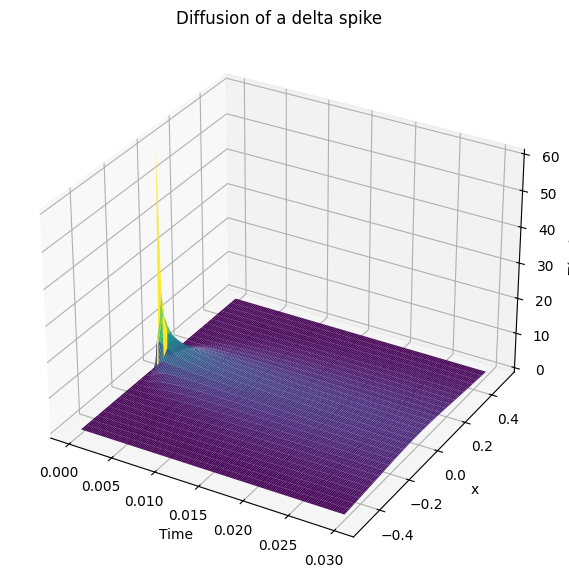

In [8]:
# Visualize explicit
doplot(xplot, tplot, tt_explicit, 'mesh')

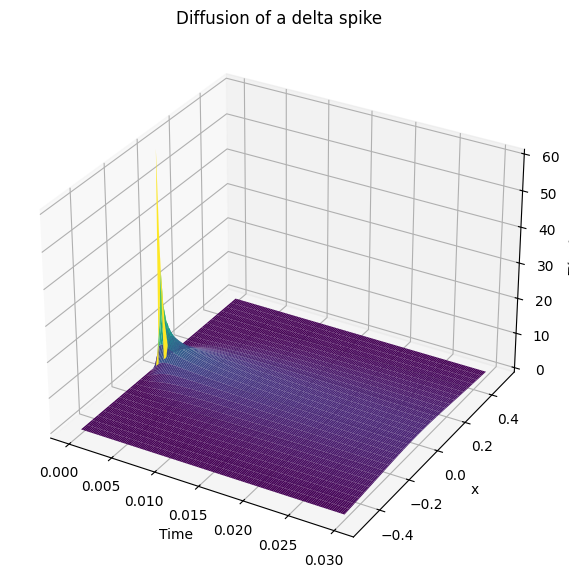

In [9]:
# Visualize implicit
doplot(xplot, tplot, tt_implicit, 'mesh')

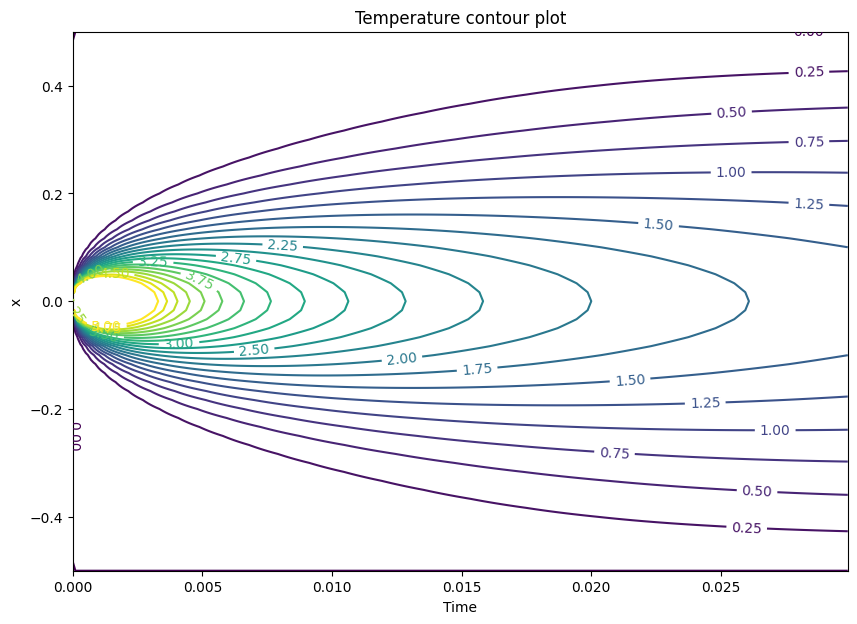

In [10]:
# Contour plot
doplot(xplot, tplot, tt_implicit, 'contour')

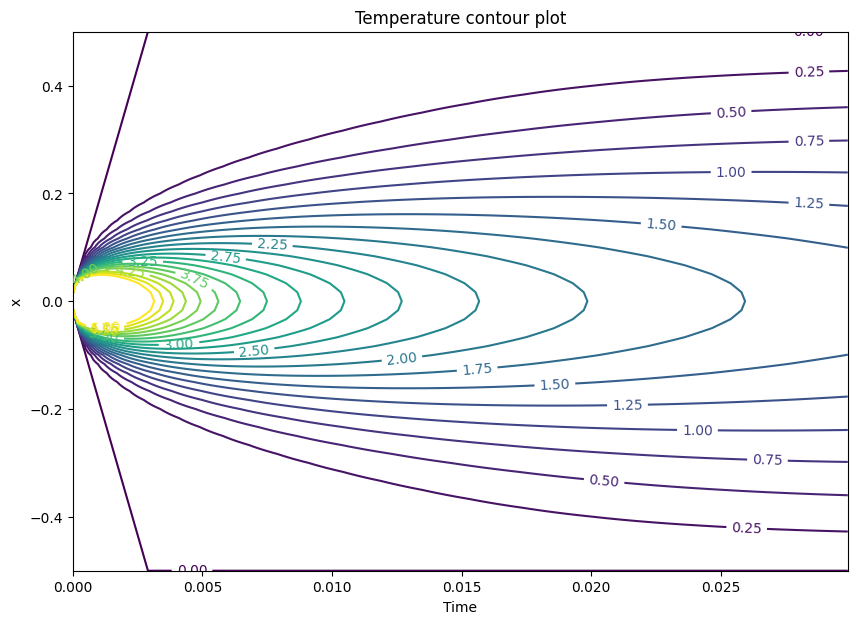

In [11]:
# Contour plot
doplot(xplot, tplot, tt_explicit, 'contour')

Maximum difference: 2.16e+01
Mean difference: 1.49e-02


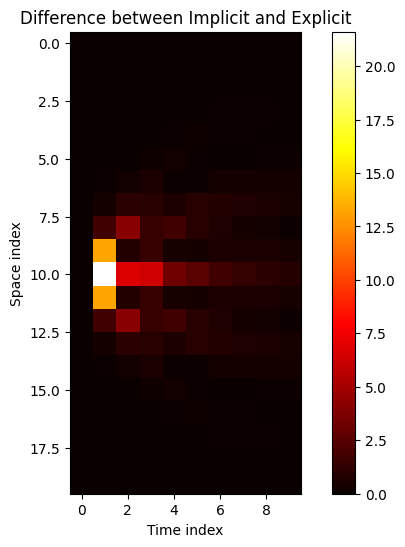

In [12]:
# Compare methods
diff = np.abs(tt_implicit - tt_explicit)
print(f"Maximum difference: {np.max(diff):.2e}")
print(f"Mean difference: {np.mean(diff):.2e}")

# Plot difference (zoomed region)
plt.figure(figsize=(8, 6))
plt.colorbar(plt.imshow(diff[20:40, 0:10], cmap='hot'))
plt.title('Difference between Implicit and Explicit')
plt.xlabel('Time index')
plt.ylabel('Space index')
plt.show()

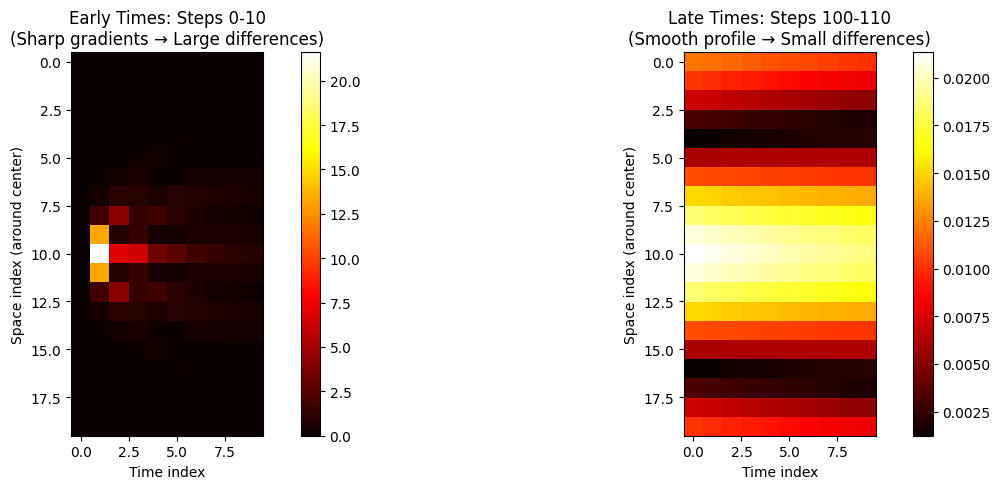


Maximum difference at early times (0-10): 2.16e+01
Maximum difference at late times (100-110): 2.13e-02
Ratio (early/late): 1012.5x larger at early times


In [13]:
# Compare early times vs late times
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Early times (sharp gradients)
im1 = ax1.imshow(diff[20:40, 0:10], cmap='hot')
ax1.set_title('Early Times: Steps 0-10\n(Sharp gradients → Large differences)')
ax1.set_xlabel('Time index')
ax1.set_ylabel('Space index (around center)')
plt.colorbar(im1, ax=ax1)

# Late times (smooth profile)
im2 = ax2.imshow(diff[20:40, 100:110], cmap='hot')
ax2.set_title('Late Times: Steps 100-110\n(Smooth profile → Small differences)')
ax2.set_xlabel('Time index')
ax2.set_ylabel('Space index (around center)')
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()

# Print statistics
early_max = np.max(diff[20:40, 0:10])
late_max = np.max(diff[20:40, 100:110])
print(f"\nMaximum difference at early times (0-10): {early_max:.2e}")
print(f"Maximum difference at late times (100-110): {late_max:.2e}")
print(f"Ratio (early/late): {early_max/late_max:.1f}x larger at early times")

### Physical Interpretation

**Early times (sharp spike):**
- Temperature changes rapidly in space and time
- High second derivatives lead to larger truncation errors
- Explicit and implicit methods use different time discretizations
- Result: **Visible differences**

**Late times (smooth):**
- Temperature profile is smooth and slowly varying
- Low gradients lead to smaller truncation errors
- Both methods approximate the same smooth function well
- Result: **Methods agree closely**